## PEFT

In [1]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [33]:
def create_rgb_segmentation(segmentation, num_classes=None):
    """
    Convert a segmentation map to an RGB visualization using a precise colormap.

    Args:
        segmentation (torch.Tensor): Segmentation map of shape [B, H, W] where
                                      each pixel contains class labels (natural numbers).
        num_classes (int): The number of unique classes in the segmentation.

    Returns:
        torch.Tensor: RGB visualization of shape [B, 3, H, W].
    """
    if len(segmentation.shape) == 4:
        segmentation = segmentation.argmax(dim=1)
    if num_classes is None:
        num_classes = segmentation.max().item() + 1
    
    # Define a precise colormap for specific classes
    colormap = torch.tensor([
        [0, 0, 0],       # Class 0: Black (Background)
        [128, 0, 0],     # Class 1: Red
        [0, 128, 0],     # Class 2: Green
        [128, 128, 0],   # Class 3: Yellow
        [0, 0, 128],     # Class 4: Blue
        [128, 0, 128],   # Class 5: Magenta
        [0, 128, 128],   # Class 6: Cyan
        [192, 192, 192], # Class 7: Light Gray
    ], dtype=torch.uint8)  # Ensure dtype is uint8

    # Initialize an empty tensor for RGB output
    B, H, W = segmentation.shape
    rgb_segmentation = torch.zeros((B, 3, H, W), dtype=torch.uint8)

    # Loop through each class and assign the corresponding RGB color
    for class_id in range(num_classes):
        # Create a mask for the current class
        class_mask = (segmentation == class_id).unsqueeze(1)  # Shape: [B, 1, H, W]
        # Assign the corresponding color to the rgb_segmentation
        rgb_segmentation += class_mask * colormap[class_id].view(1, 3, 1, 1)  # Broadcasting

    return rgb_segmentation

In [92]:
from peft import LoraConfig, get_peft_model
from tqdm import tqdm
from label_anything.loss import LabelAnythingLoss
from label_anything.experiment.substitution import Substitutor
from label_anything.utils.metrics import DistributedMulticlassJaccardIndex, to_global_multiclass
from torch.optim import AdamW

import lovely_tensors as lt
import torch
lt.monkey_patch()

In [3]:
from label_anything.data import get_dataloaders
from label_anything.models import model_registry
from label_anything.utils.utils import torch_dict_load

In [4]:
dataset_args = {
    'datasets': {
        'coco20i': {
            'name': 'coco',
            'instances_path': 'data/coco/annotations/instances_train2014.json',
            'emb_dir': 'data/coco/vit_b_sam_embeddings/last_block_state',
            'img_dir': 'data/coco/train_val_2017',
            'split': 'train',
            'val_fold_idx': 3,
            'n_folds': 4,
            'sample_function': 'uniform',
            'all_example_categories': False,
        },
        'val_coco20i_N2K5': {
            'name': 'coco',
            'instances_path': 'data/coco/annotations/instances_val2014.json',
            'emb_dir': 'data/coco/vit_b_sam_embeddings/last_block_state',
            'img_dir': 'data/coco/train_val_2017',
            'split': 'val',
            'val_fold_idx': 3,
            'n_folds': 4,
            'n_shots': 5,
            'n_ways': 2,
            'do_subsample': False,
            'add_box_noise': False,
        },
    },
    'common': {
        'remove_small_annotations': True,
        'do_subsample': False,
        'add_box_noise': True,
        'max_points_annotations': 70,
        'max_points_per_annotation': 10,
        'load_gts': False,
        'image_size': 480,
        "load_embeddings": False,
        "custom_preprocess": False,
    }
}

dataloader_args = {
    'num_workers': 0,
    'possible_batch_example_nums': [[1, 2, 4]],
    'val_possible_batch_example_nums': [[1, 1]],
    'prompt_types': ["mask"],
    'prompt_choice_level': ["episode"],
    'val_prompt_types': ["mask"],
}

In [5]:
train, val_dict, test = get_dataloaders(dataset_args, dataloader_args, num_processes=1)
val = val_dict['val_coco20i_N2K5']

Loading dataset annotations from data/coco/annotations/instances_train2014.json...
Loading dataset annotations from data/coco/annotations/instances_val2014.json...


In [88]:
substitutor = Substitutor(
    threshold=None,
    num_points=1,
    substitute=True,
    long_side_length=480,
    custom_preprocess=False,
)

### Get Model

In [105]:
model_params = {
    'class_attention': True,
    'example_class_attention': True,
    'class_encoder': {
        'bank_size': 100,
        'embed_dim': 256,
        'name': 'RandomMatrixEncoder'
    },
    'embed_dim': 256,
    'example_attention': True,
    'example_class_attention': True,
    'fusion_transformer': 'TwoWayTransformer',
    'image_embed_dim': 768,
    'image_size': 480,
    'spatial_convs': 3,
    'use_vit_sam_neck': False,
    "custom_preprocess": False,
}

name = "lam_mae_b"
path = "offline/wandb/generated-run-y04k97k7/files/best/model.safetensors"

In [106]:
model = model_registry[name](**model_params)
weights = torch_dict_load(path)
weights = {k[6:]: v for k, v in weights.items()}

You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of ViTModelWrapper were not initialized from the model checkpoint at facebook/vit-mae-base and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [107]:
keys = model.load_state_dict(weights, strict=False)
for key in keys.missing_keys:
    if key.startswith("image_encoder"):
        continue
    print(f"Missing key: {key}")
for key in keys.unexpected_keys:
    print(f"Unexpected key: {key}")

### PEFT

In [108]:
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    # modules_to_save=["classifier"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 589824 || all params: 99486892 || trainable%: 0.59


In [28]:
loss = LabelAnythingLoss(
    **{"class_weighting": True, 
       "components": {"focal": {"weight": 1.0}}
       }
    )

In [44]:
optimizer = AdamW(lora_model.parameters(), lr=1e-3)

In [60]:
miou = DistributedMulticlassJaccardIndex(
                    num_classes=80 + 1,
                    average="macro",
                    ignore_index=-100,
                )
dataset_categories = next(iter(val.dataset.datasets.values())).categories

In [104]:
batch_tuple, data_name = next(iter(val))

In [129]:
segmentation_gt = create_rgb_segmentation(batch_tuple[1][:, 0].cpu())

In [133]:
num_iterations = 5
device = "cuda"

In [136]:
lora_model = lora_model.to(device)
batch_dict = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch_tuple[0].items()}
batch_gt = batch_tuple[1].to(device)
batch_tuple = (batch_dict, batch_gt)
miou.to(device)

DistributedMulticlassJaccardIndex()

In [140]:
mious = []
losses = []
segmentation_preds = []
for k in range(num_iterations):
    substitutor.reset(batch=batch_tuple)
    num_examples = batch_tuple[0]['images'].shape[1]
    bar = tqdm(enumerate(substitutor), total=num_examples+1)
    for i, (batch, gt) in bar:
        if i == num_examples:
            break
        bar.set_description(f"iteration {k} | batch {i}")
        optimizer.zero_grad()
        res = lora_model(batch)
        loss_value = loss(res, gt)
        if i != 0:
            loss_value.backward()
            optimizer.step()
        segmentation_pred = create_rgb_segmentation(res['logits'].cpu())
        preds = res['logits'].argmax(dim=1)
        glob_preds, glob_gt = to_global_multiclass(
                            batch["classes"], dataset_categories, preds, gt
                        )
        miou_value = miou(glob_preds, glob_gt)
        if i == 0:
            mious.append(miou_value)
            losses.append(loss_value)
            segmentation_preds.append(segmentation_pred)
        bar.set_postfix(loss=loss_value.item(), miou=miou_value.item())
    print(f"miou: {mious[-1]}, loss: {losses[-1]}")

iteration 0 | batch 0:   0%|          | 0/12 [00:00<?, ?it/s]

iteration 0 | batch 10:  92%|█████████▏| 11/12 [00:03<00:00,  3.56it/s, loss=0.118, miou=0.591]


miou: 0.3191254734992981, loss: 0.13789688050746918


iteration 1 | batch 1:   8%|▊         | 1/12 [00:00<00:01,  5.65it/s, loss=0.138, miou=0.319]


OutOfMemoryError: CUDA out of memory. Tried to allocate 410.00 MiB. GPU 0 has a total capacity of 23.64 GiB of which 397.50 MiB is free. Including non-PyTorch memory, this process has 23.16 GiB memory in use. Of the allocated memory 22.24 GiB is allocated by PyTorch, and 443.06 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

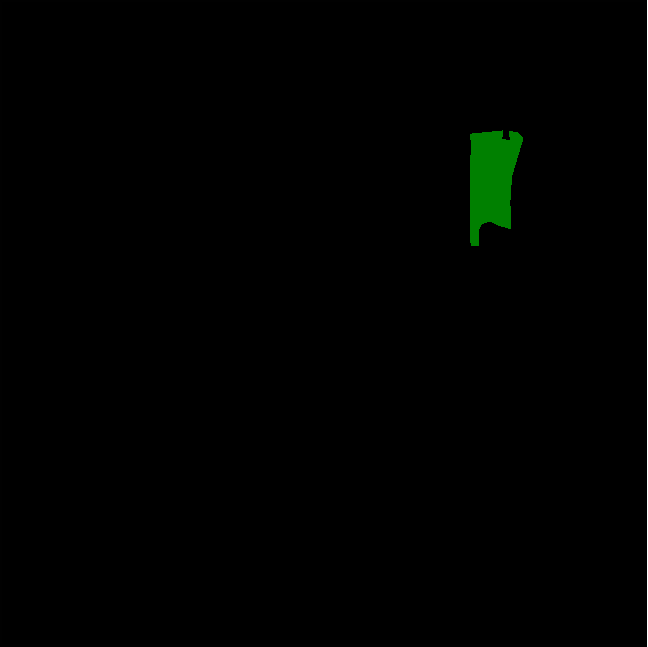

In [138]:
segmentation_gt.rgb

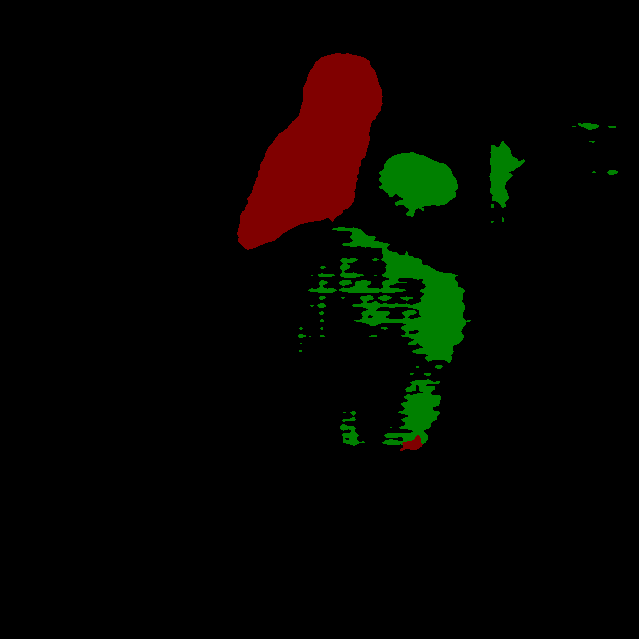

In [139]:
segmentation_preds[1][0].rgb

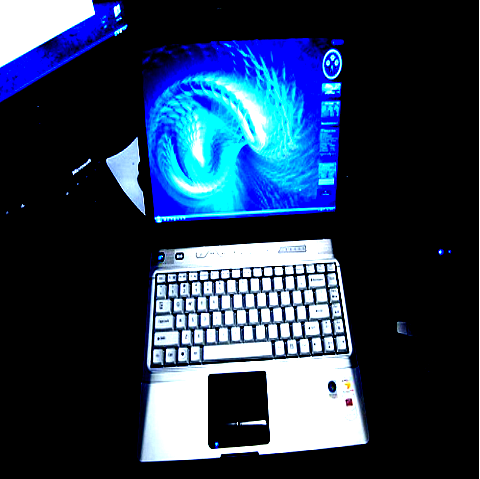

In [77]:
batch['images'][0, 0].rgb

In [83]:
optimizer.zero_grad()
res = lora_model(batch)
loss_value = loss(res, gt)
print(loss_value)
loss_value.backward()
optimizer.step()


tensor grad AddBackward0 0.363


In [84]:
preds = res['logits'].argmax(dim=1)

In [85]:
segmentation_pred = create_rgb_segmentation(res['logits'])
segmentation_gt = create_rgb_segmentation(gt)

glob_preds, glob_gt = to_global_multiclass(
                    batch["classes"], dataset_categories, preds, gt
                )
miou_value = miou(glob_preds, glob_gt)
print(miou_value)

tensor 0.444


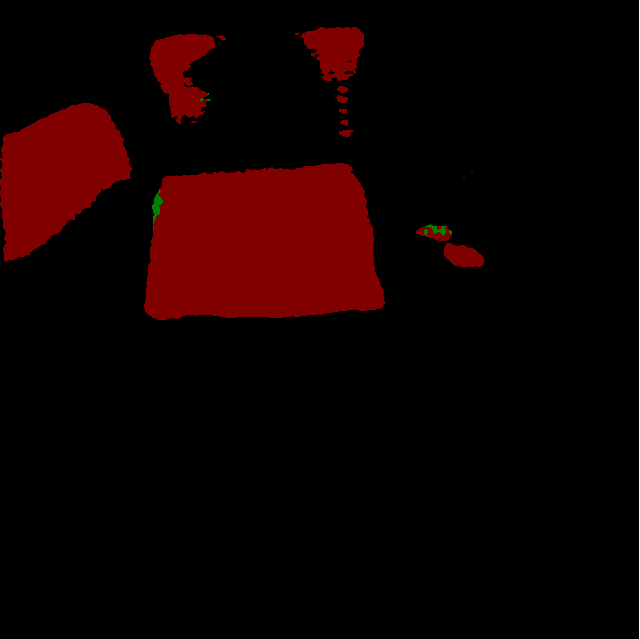

In [86]:
segmentation_pred[0].rgb

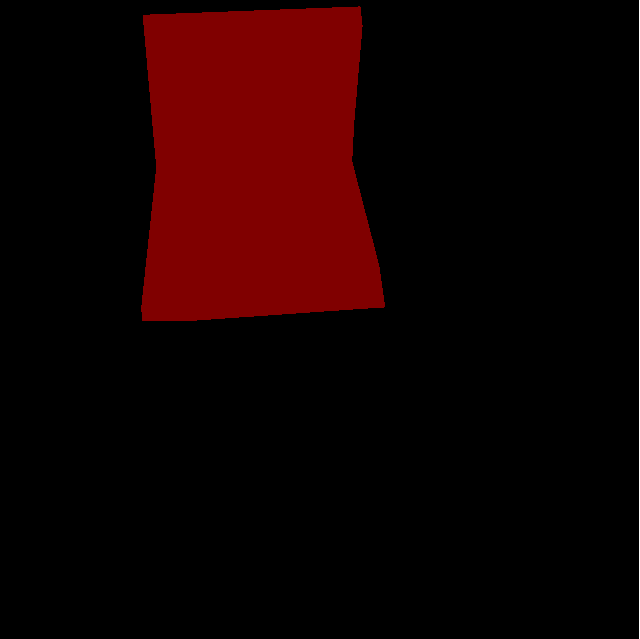

In [87]:
segmentation_gt[0].rgb